Replication of Figure 6(A)from [The Temporal Dynamics of Aperiodic Neural Activity Track Changes in Sleep Architecture](https://www.biorxiv.org/content/10.1101/2024.01.25.577204v1.full) \
Orginal image: \
N1 = light sleep transition from wakefullness to sleep \
N2 = light to moderate (spindles etc) \
N3 = Deep slow wave, restoritive

<img src="./orginal_image.png" width="600" height="300">


In [31]:
import numpy as np, matplotlib.pyplot as plt
from scipy import signal, io
from scipy.ndimage import gaussian_filter
from fooof import FOOOF


Load all 3 datasets HPC EEG, PFC EEG and the states

In [34]:
states_mat = io.loadmat('OverlappingOR_data/2018-07-30_15-40-25_Post-Trial5-states.mat')
hpc_mat = io.loadmat('OverlappingOR_data/HPC_100_CH4_0.continuous.mat')
pfc_mat = io.loadmat('OverlappingOR_data/PFC_100_CH47_0.continuous.mat')

states = states_mat['states']
hpc_data = hpc_mat['HPC']
pfc_data = pfc_mat['PFC']

# flatten to 1d since its easier to work with
states   = states.ravel()
hpc_data = hpc_data.ravel()
pfc_data = pfc_data.ravel()

print(f"States shape: {states.shape}")
print(f"HPC shape: {hpc_data.shape}")
print(f"PFC shape: {pfc_data.shape}")

States shape: (10800,)
HPC shape: (10800845,)
PFC shape: (10800845,)


# States graph alone

In [35]:
def visualize_states(state_data):
    state_map = {
        1: 'Wake',
        3: 'NREM',
        4: 'Intermediate',
        5: 'REM'
    }

    unique_codes = sorted(state_map.keys())
    unique_labels = [state_map[code] for code in unique_codes]

    epoch_length_sec = 1
    time = np.arange(len(state_data)) * epoch_length_sec / 360

    fig, ax = plt.subplots(figsize=(12, 3))
    ax.step(time, state_data, where='post', color='k')
    ax.set_yticks(unique_codes)
    ax.set_yticklabels(unique_labels)
    ax.set_xlabel('Time (hours)')
    ax.set_ylabel('Stages')
    ax.set_title('Hypnogram')
    plt.tight_layout()
    
    return ax

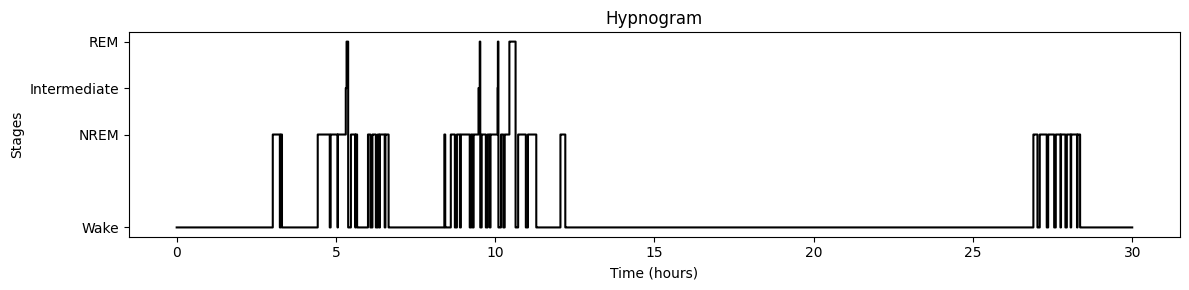

In [36]:
visualize_states(state_data=states)
plt.show()

All parameter settings are taken from the paper

In [37]:
def visualize_spectrogram(
        eeg,
        sample_freq   = 1000,      # Sample rate of data is 1000hz 
        adc_scale_uv  = 0.195 ,    # ADC scale µV to conver and match the legend from the paper
        window_sec    = 15,        # "We used Welch’s method with 15 s segments and 50% overlap" (Ameen et al., 2024, Section 2.4.1).
        fmax          = 30,        # "We limited frequency analysis to ≤ 45 Hz, often reporting fmax = 30 Hz" (Fig. 6 & others)
        smooth_sigma  = (0, 1),    # "Gaussian filter applied to smooth spectrograms" (Fig. 6A & Supplement)
        pct_clip      = (2, 98),   # Clip values at 2 and 98 percentiles, not mentioned in the paper but used to have a visusally meaningful plot
        title         = None,     
):
    
    eeg = np.asarray(eeg, dtype=np.float64).ravel()
    eeg *= adc_scale_uv


    nperseg  = window_sec * sample_freq
    noverlap = nperseg // 2
    nfft     = max(2048, 1 << (nperseg - 1).bit_length())


    f, t, Ppsd = signal.spectrogram(
        eeg, sample_freq, window='hamming',
        nperseg=nperseg, noverlap=noverlap, nfft=nfft,
        detrend='constant', scaling='density', mode='psd'
    )

    bin_w   = sample_freq / nfft                   
    keep    = f <= fmax
    f       = f[keep]
    P_lin   = Ppsd[keep] * bin_w       
    if smooth_sigma is not None:
        P_lin = gaussian_filter(P_lin, sigma=smooth_sigma)

    vmin, vmax = np.percentile(P_lin, pct_clip)


    _, ax = plt.subplots(figsize=(12, 3.5), facecolor='w')

    t_hr = (t + window_sec/2) / 3600
    pcm  = ax.pcolormesh(t_hr, f, P_lin, shading='gouraud',
                         vmin=vmin, vmax=vmax, cmap='viridis')
    ax.set_xlim(0, eeg.size/sample_freq/3600)
    ax.set_ylim(0, fmax)
    ax.set_xlabel('time (h)')
    ax.set_ylabel('frequency (Hz)')
    ax.set_title(title or 'Spectrogram')
    cb = ax.figure.colorbar(pcm, ax=ax, label='power (µV²)')
    plt.tight_layout()
    return ax


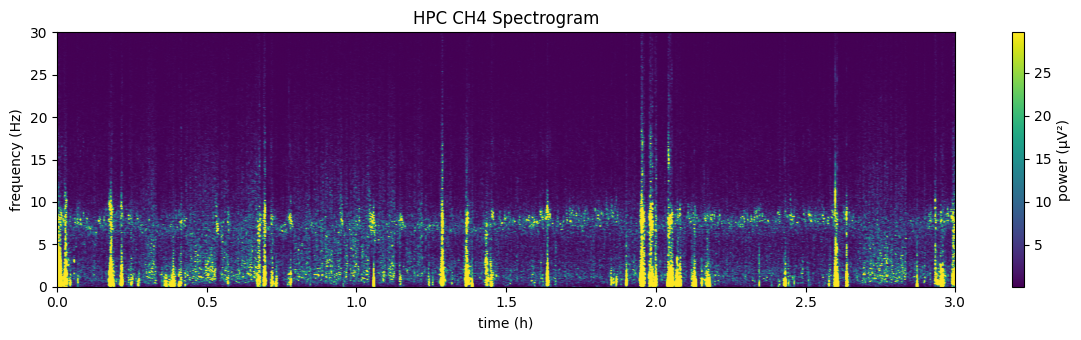

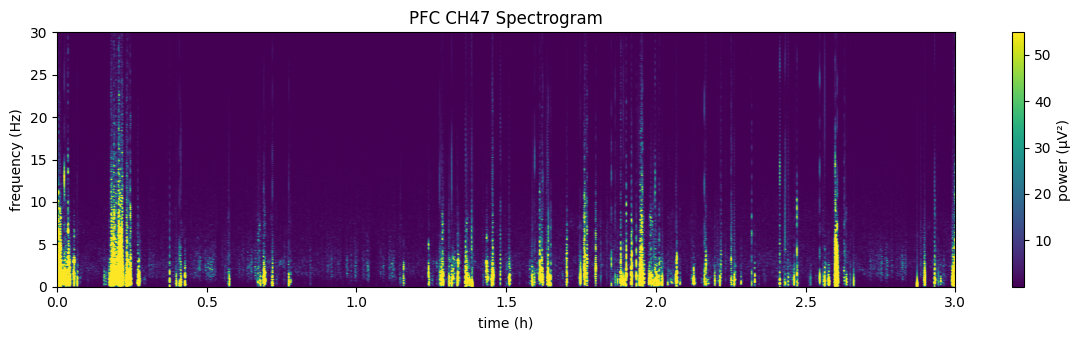

In [38]:
visualize_spectrogram(hpc_data, title='HPC CH4 Spectrogram')
plt.show()

visualize_spectrogram(pfc_data, title='PFC CH47 Spectrogram')
plt.show()

In [39]:
def plot_combined_spectrogram_and_states(
        eeg_data, 
        states, 
        title,
        sample_freq=1000,      # Sample rate of data is 1000hz 
        adc_scale_uv=0.195,    # ADC scale µV to conver and match the legend from the paper
        window_sec=15,         # "We used Welch’s method with 15 s segments and 50% overlap" (Ameen et al., 2024, Section 2.4.1).
        fmax=30,               # "We limited frequency analysis to ≤ 45 Hz, often reporting fmax = 30 Hz" (Fig. 6 & others)
        smooth_sigma=(0, 1),   # "Gaussian filter applied to smooth spectrograms" (Fig. 6A & Supplement)
        pct_clip=(2, 98),      # Clip values at 2 and 98 percentiles, not mentioned in the paper but used to have a visusally meaningful plot
        exponent_range=(1, 30) # "We used a range of 1 to 30 for the exponent" (Ameen et al., 2024, Section 2.4.1).
        
    ):

    from matplotlib.gridspec import GridSpec

    # all grid stuff
    fig = plt.figure(figsize=(12, 7))
    gs = GridSpec(3, 2, width_ratios=[20, 1], height_ratios=[1, 1, 3], wspace=0.05, hspace=0.2)
    ax0 = fig.add_subplot(gs[0, 0])
    ax1 = fig.add_subplot(gs[1, 0]) 
    ax2 = fig.add_subplot(gs[2, 0])  
    cax = fig.add_subplot(gs[2, 1]) 

    # prepare EEG data
    data = eeg_data.astype(np.float64)

    # convert to uV to match the legenda from the paper
    data *= adc_scale_uv

    # spectrogram parameters
    nperseg = window_sec * sample_freq
    noverlap = nperseg // 2
    nfft = max(2048, 1 << (nperseg-1).bit_length())

    f, t, Ppsd = signal.spectrogram(data, sample_freq, 'hamming', nperseg, noverlap,
                                    nfft=nfft, detrend='constant',
                                    scaling='density', mode='psd')
    bin_w = sample_freq / nfft
    keep = f <= fmax
    f = f[keep]
    Ppsd = Ppsd[keep]

    # compute the exponent using FOOOF
    exponents = []
    print(f'Computing exponents on {Ppsd.shape[1]} channels')
    for i in range(Ppsd.shape[1]):
        fm = FOOOF(aperiodic_mode='fixed', verbose=False)
        try:
            fm.fit(f, Ppsd[:, i], exponent_range)
            exponents.append(fm.aperiodic_params_[1])
        except:
            exponents.append(np.nan) 
        
        # log progress every 10% since floof calcuations (via my for loop, prob better ways)
        if i % (Ppsd.shape[1] // 10) == 0:
            print(f'{round(i / Ppsd.shape[1] * 100)}% done')

    exponents = np.array(exponents)
    time_h = (t + window_sec / 2) / 3600 

    # plot exponent 
    ax0.plot(time_h, exponents, color='red', linewidth=1)
    ax0.set_ylabel('Exponent')  
    ax0.set_xlim(0, max(time_h))
    ax0.set_xticks([])
    
    # plot spectorogram with guassian smoothing 
    P_lin = gaussian_filter(Ppsd * bin_w, sigma=smooth_sigma)
    vmin, vmax = np.percentile(P_lin, pct_clip)


    pcm = ax2.pcolormesh(time_h, f, P_lin, shading='gouraud',
                         vmin=vmin, vmax=vmax, cmap='viridis')
    plt.colorbar(pcm, cax=cax, label='power (µV²)')
 

    # plot the states
    state_map = {
        1: 'Wake',
        3: 'NREM',
        4: 'Intermediate',
        5: 'REM'
    }
    states = states.flatten()
    unique_codes = sorted(state_map.keys())
    unique_labels = [state_map[code] for code in unique_codes]
    epoch_length_sec = 1
    time = np.arange(len(states)) * epoch_length_sec / 3600


    ax1.step(time, states, where='post', color='k', linewidth=1)
    ax1.set_yticks(unique_codes)
    ax1.set_yticklabels(unique_labels)
    ax1.set_ylabel('Stages')
    ax1.invert_yaxis()
    ax1.set_xticks([])
    
    ax2.set_xlabel('Time (hours)')

    fig.patch.set_facecolor('white')
    ax0.set_facecolor('white')
    ax1.set_facecolor('white')
    ax2.set_facecolor('white')

    fig.suptitle(title, fontsize=16, y=0.98)
    plt.show()




In [ ]:
plot_combined_spectrogram_and_states(pfc_data, states, title='States & PFC continuous')

Computing exponents on 1439 channels
0.0% done
9.9% done
19.9% done
29.8% done
39.7% done
49.7% done
59.6% done
69.6% done


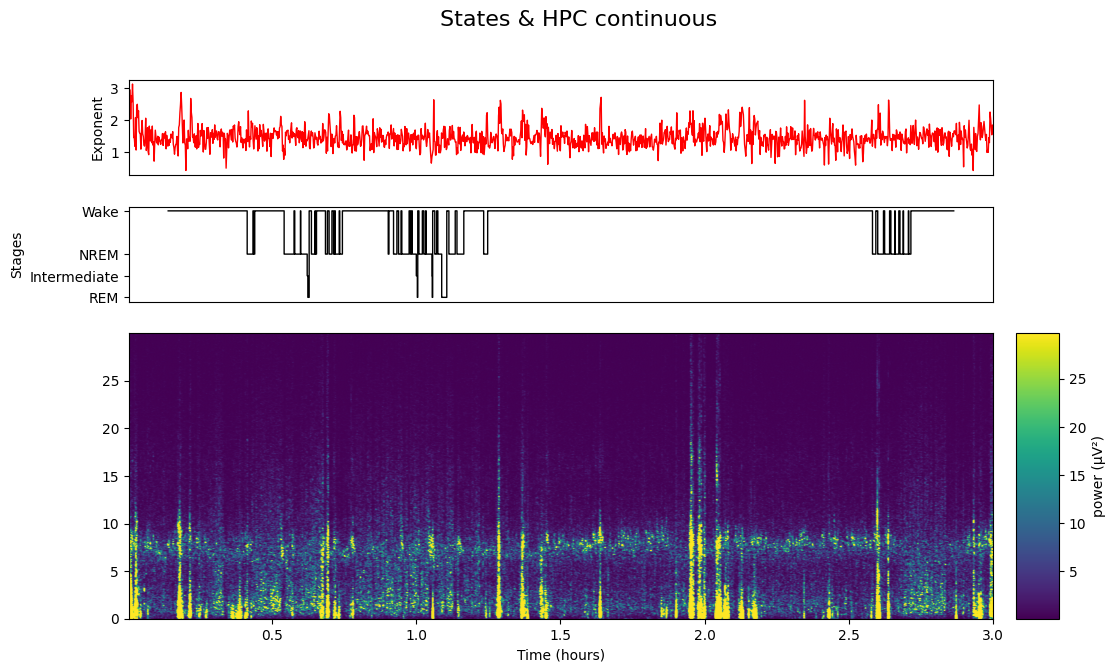

In [ ]:
plot_combined_spectrogram_and_states(hpc_data, states, title='States & HPC continuous')